## Exploratory Data Analysis

In [2]:
import numpy as np
import pandas as pd
pd.set_option('max_columns', 150)

# matplotlib and seaborn for plotting
import matplotlib
matplotlib.rcParams['figure.dpi'] = 120 #resolution
matplotlib.rcParams['figure.figsize'] = (8,6) #figure size
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
color = sns.color_palette()

root = '/Volumes/GoogleDrive/My Drive/DataMinin255/Project/InstaCart/'

## Data

In [3]:
aisles = pd.read_csv('aisles.csv')
departments = pd.read_csv('departments.csv')
orders = pd.read_csv('orders.csv')
order_products_prior = pd.read_csv('order_products__prior.csv')
order_products_train = pd.read_csv('order_products__train.csv')
products = pd.read_csv('products.csv')

Checking above dataframes

In [4]:
aisles.head()

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


In [5]:
departments.head()

,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol


In [6]:
products.head()

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


In [7]:
orders.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [8]:
order_products_prior.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [9]:
order_products_train.head()

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


## EDA

### Let's find out how th data is divided into train and test set

In [5]:
def get_unique_count(x):
    return len(np.unique(x))

cnt_srs = orders.groupby("eval_set")["user_id"].aggregate(get_unique_count)
cnt_srs

eval_set
prior    206209
test      75000
train    131209
Name: user_id, dtype: int64

#### Out of 206,209 customer data, the last order of 131,209 customers are put into train dataset and
#### last order of 75,000 customers are put into test dataset.

### Order Frequency of Customers

C:\Users\Sweta\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


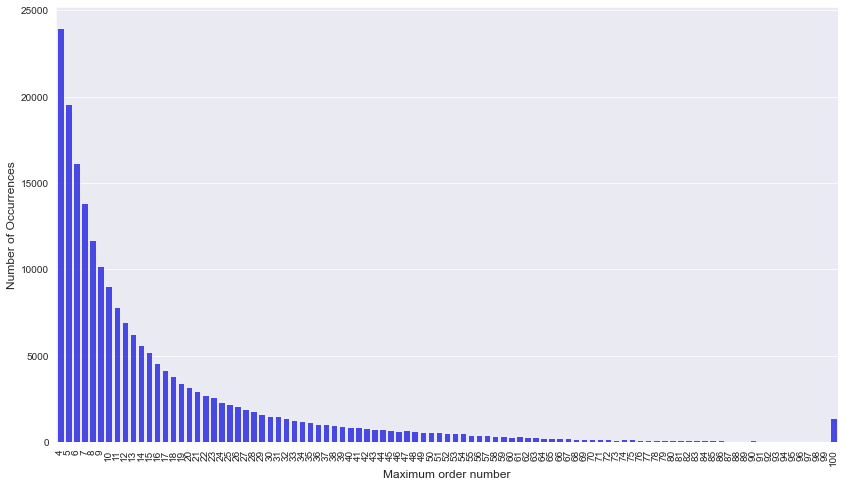

In [65]:
cnt_srs = orders.groupby("user_id")["order_number"].aggregate(np.max).reset_index()
cnt_srs = cnt_srs.order_number.value_counts()

plt.figure(figsize=(14,8))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8, color='blue')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Maximum order number', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

## Order Frequency in a Week

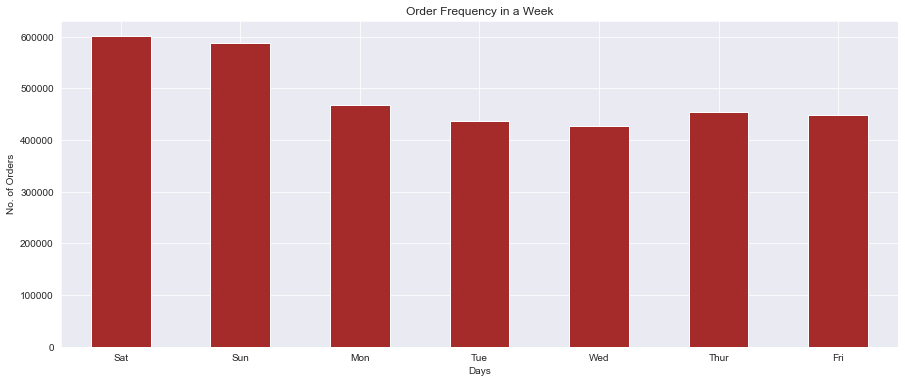

In [67]:
order_freq_week = orders['order_dow'].value_counts().sort_index()
order_freq_week.index=['Sat', 'Sun', 'Mon', 'Tue', 'Wed', 'Thur', 'Fri']
fig = plt.figure(figsize=(15,6))
order_freq_week.plot(kind='bar', color='brown')
plt.xticks(rotation=0)
plt.title('Order Frequency in a Week')
plt.xlabel('Days')
plt.ylabel('No. of Orders')
plt.show()

## Order Frequency for Hour of the Day

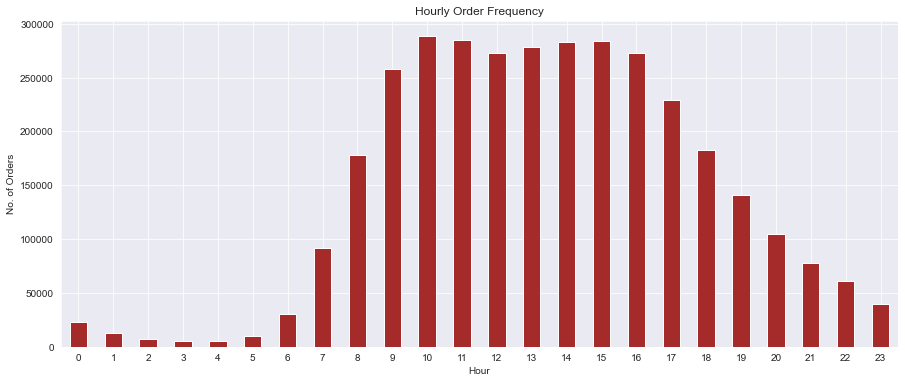

In [11]:
order_freq_hour = orders['order_hour_of_day'].value_counts().sort_index()
fig = plt.figure(figsize=(15,6))
order_freq_hour.plot(kind='bar', color='brown')
plt.xticks(rotation=0)
plt.title('Hourly Order Frequency')
plt.xlabel('Hour')
plt.ylabel('No. of Orders')
plt.show()

## Number of Orders in a week vs Hour of a day

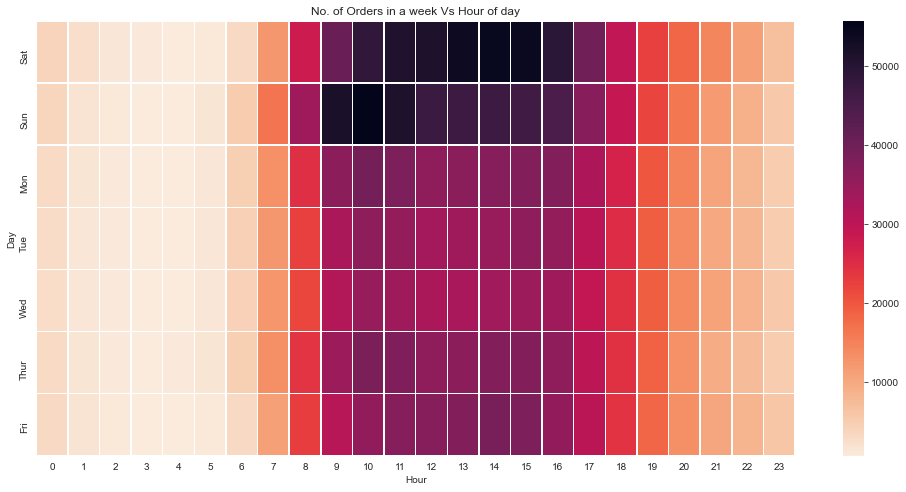

In [12]:
grouped_df = orders.groupby(["order_dow", "order_hour_of_day"])["order_number"].aggregate("count").reset_index()
grouped_df = grouped_df.pivot('order_dow', 'order_hour_of_day', 'order_number')

grouped_df.index=['Sat', 'Sun', 'Mon', 'Tue', 'Wed', 'Thur', 'Fri']

plt.figure(figsize=(17,8))
# sns.color_palette("viridis", as_cmap=True)
sns.heatmap(grouped_df, linewidths=.5, cmap='rocket_r')
plt.title("No. of Orders in a week Vs Hour of day")
plt.xlabel('Hour')
plt.ylabel('Day')
plt.show()

## Re-Order Interval

In [13]:
order_interval_count = orders.groupby('days_since_prior_order')['order_id'].agg('count')

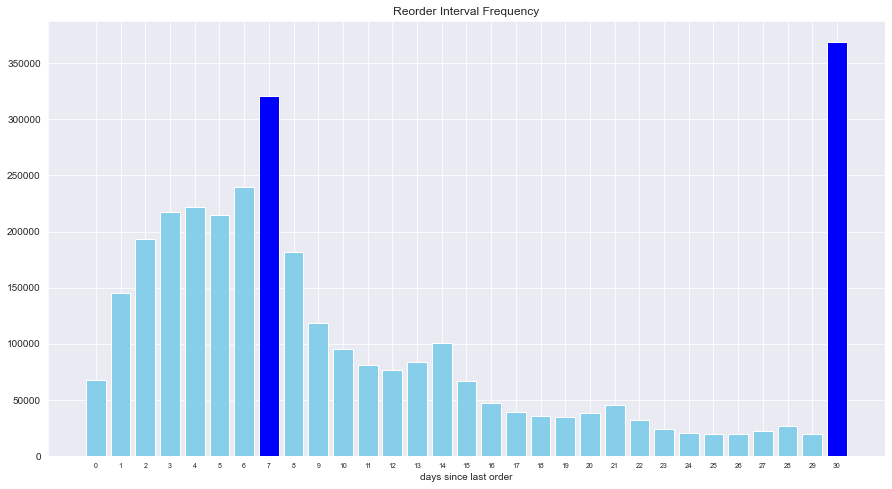

In [16]:

fig = plt.figure(figsize=(15,8))
color_list = ['skyblue'] * len(order_interval_count.index)
color_list[7] = 'blue'
color_list[30] = 'blue'    
plt.bar(order_interval_count.index, order_interval_count, color=color_list)
plt.xticks(np.arange(len(order_interval_count.index)), rotation=0,fontsize=7)
plt.xlabel('days since last order')
plt.title('Reorder Interval Frequency')
plt.show()
fig.set_dpi(200)

## Popular Items in Shopping Cart History

In this part, let's see what are the most popular items on customers' order lists.

First take a look at each dataset, and then merge them into one dataframe with all the following included:
* user_id
* order_id
* product_id
* product_name

In [17]:
# All orders (prior & train): order_id, product_id
All_Order_Product=pd.concat([order_products_prior, order_products_train])

In [18]:
# orders in prior/train merged with product names
Order_Product_Name_Prior = pd.merge(order_products_prior, 
                                    products, how='left', on='product_id')
Order_Product_Name_Train = pd.merge(order_products_train, 
                                    products, how='left', on='product_id')

In [20]:
# Prior orders with user_id, product_id, product_name
Prior_User_Order_Product = pd.merge(Order_Product_Name_Prior, 
                                    orders, how='left', on='order_id')

In [21]:
# Now we have all we need: order_id, product_id, user_id, product_name
Prior_User_Order_Product.head() 

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2,33120,1,1,Organic Egg Whites,86,16,202279,prior,3,5,9,8.0
1,2,28985,2,1,Michigan Organic Kale,83,4,202279,prior,3,5,9,8.0
2,2,9327,3,0,Garlic Powder,104,13,202279,prior,3,5,9,8.0
3,2,45918,4,1,Coconut Butter,19,13,202279,prior,3,5,9,8.0
4,2,30035,5,0,Natural Sweetener,17,13,202279,prior,3,5,9,8.0


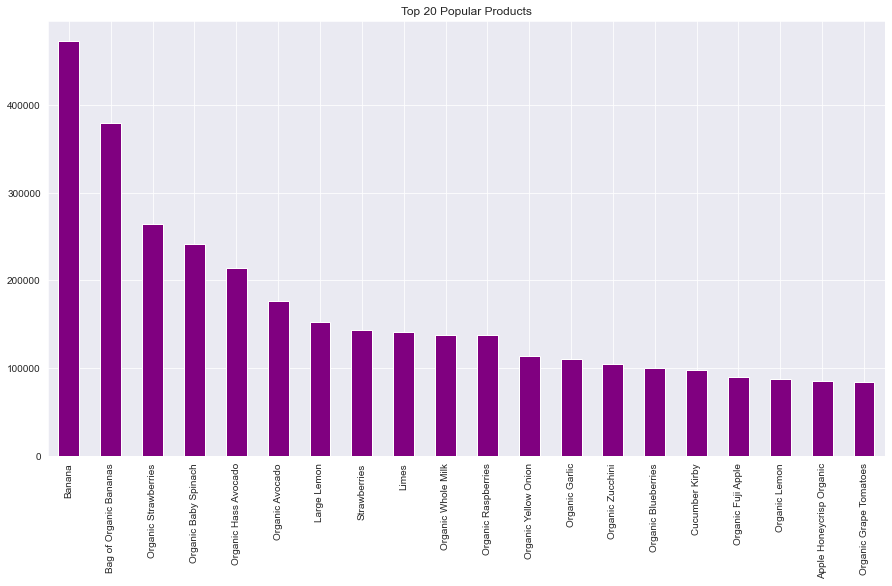

In [33]:
# top 20 most popular products
Products_Count = Prior_User_Order_Product['product_name'].value_counts()
fig = plt.figure(figsize=(15,8))
Products_Count[0:20].plot(kind="bar", color='purple')
plt.xticks(rotation=90)
plt.title('Top 20 Popular Products')
plt.show()
#fig.set_dpi(200)
#fig.savefig('../figs/Top_20_Popular_Products.png')

In [23]:
products_tuple_list = [tuple(x) for x in Products_Count.reset_index().values]

In [24]:
dic = {}
for pair in products_tuple_list:
    key = pair[0]
#     print(type(key))
    value = pair[1]
#     print(type(value))
    if key in dic:
        reservedValue = dic[key]
        reservedValue += value 
    else:
        dic[key] = value

In [27]:
from wordcloud import WordCloud

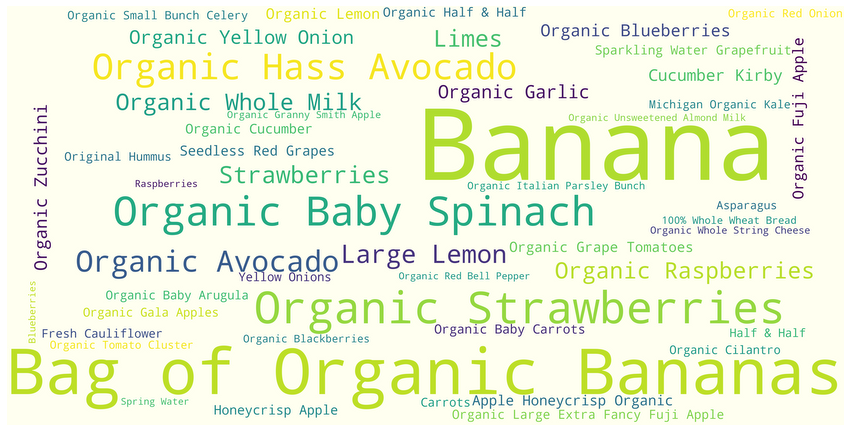

In [73]:
from wordcloud import WordCloud

fig = plt.figure(figsize=(15,8))
wordcloudData = WordCloud(width=4096,height=2048,
                          relative_scaling=1,
                          max_words = 50,
                          background_color='ivory',
                          ).generate_from_frequencies(frequencies = dic)
plt.imshow(wordcloudData, interpolation='lanczos')
plt.axis("off")
plt.show()
fig.set_dpi(200)
# fig.savefig('../figs/wordcloud.png',bbox_inches='tight')

In [47]:
# percentage of re-orders in prior set #
order_products_prior.reordered.sum() / order_products_prior.shape[0]

0.5896974667922161

In [48]:
# percentage of re-orders in train set #
order_products_train.reordered.sum() / order_products_train.shape[0]

0.5985944127509629

In [74]:
grouped_df

,order_id,add_to_cart_order
0,1,8
1,36,8
2,38,9
3,96,7
4,98,49
...,...,...
131204,3421049,6
131205,3421056,5
131206,3421058,8
131207,3421063,4


C:\Users\Sweta\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


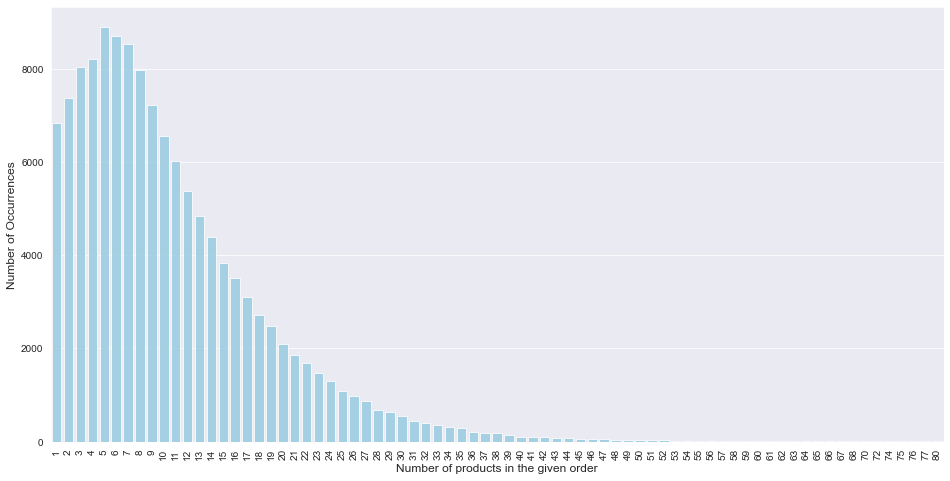

In [57]:
grouped_df = order_products_train.groupby("order_id")["add_to_cart_order"].aggregate("max").reset_index()
cnt_srs = grouped_df.add_to_cart_order.value_counts()

plt.figure(figsize=(16,8))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8, color='skyblue')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Number of products in the given order', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

## Data preparation

For Analysis, I am combining order_products_train and order_products_prior as order_products. Based on order_id, product_id, aisle_id and department_id I will merge those data with order_products and will create one single dataframe.

In [9]:
order_products = order_products_prior.append(order_products_train)
order_products.shape

(33819106, 4)

In [10]:
order_products = order_products.merge(products, on ='product_id', how='left')
order_products = order_products.merge(aisles, on ='aisle_id', how='left')
order_products = order_products.merge(departments, on ='department_id', how='left')
order_products = order_products.merge(orders, on='order_id', how='left')
order_products.shape

(33819106, 15)

In [11]:
order_products.head()

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle,department,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2,33120,1,1,Organic Egg Whites,86,16,eggs,dairy eggs,202279,prior,3,5,9,8.0
1,2,28985,2,1,Michigan Organic Kale,83,4,fresh vegetables,produce,202279,prior,3,5,9,8.0
2,2,9327,3,0,Garlic Powder,104,13,spices seasonings,pantry,202279,prior,3,5,9,8.0
3,2,45918,4,1,Coconut Butter,19,13,oils vinegars,pantry,202279,prior,3,5,9,8.0
4,2,30035,5,0,Natural Sweetener,17,13,baking ingredients,pantry,202279,prior,3,5,9,8.0


In [12]:
order_products.tail()

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle,department,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
33819101,3421063,14233,3,1,Natural Artesian Water,115,7,water seltzer sparkling water,beverages,169679,train,30,0,10,4.0
33819102,3421063,35548,4,1,Twice Baked Potatoes,13,20,prepared meals,deli,169679,train,30,0,10,4.0
33819103,3421070,35951,1,1,Organic Unsweetened Almond Milk,91,16,soy lactosefree,dairy eggs,139822,train,15,6,10,8.0
33819104,3421070,16953,2,1,Creamy Peanut Butter,88,13,spreads,pantry,139822,train,15,6,10,8.0
33819105,3421070,4724,3,1,Broccoli Florettes,32,4,packaged produce,produce,139822,train,15,6,10,8.0


In [13]:
order_products.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33819106 entries, 0 to 33819105
Data columns (total 15 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   order_id                int64  
 1   product_id              int64  
 2   add_to_cart_order       int64  
 3   reordered               int64  
 4   product_name            object 
 5   aisle_id                int64  
 6   department_id           int64  
 7   aisle                   object 
 8   department              object 
 9   user_id                 int64  
 10  eval_set                object 
 11  order_number            int64  
 12  order_dow               int64  
 13  order_hour_of_day       int64  
 14  days_since_prior_order  float64
dtypes: float64(1), int64(10), object(4)
memory usage: 4.0+ GB


#### Reducing memory usage for faster analysis

In [14]:
def reduce_memory(df):
    
    """
    This function reduce the dataframe memory usage by converting it's type for easier handling.
    
    Parameters: Dataframe
    Return: Dataframe
    """
    
    start_mem_usg = df.memory_usage().sum() / 1024**2 
    print("Memory usage of properties dataframe is :",start_mem_usg," MB")
    
    for col in df.columns:
        if df[col].dtypes in ["int64", "int32", "int16"]:
            
            cmin = df[col].min()
            cmax = df[col].max()
            
            if cmin > np.iinfo(np.int8).min and cmax < np.iinfo(np.int8).max:
                df[col] = df[col].astype(np.int8)
            
            elif cmin > np.iinfo(np.int16).min and cmax < np.iinfo(np.int16).max:
                df[col] = df[col].astype(np.int16)
            
            elif cmin > np.iinfo(np.int32).min and cmax < np.iinfo(np.int32).max:
                df[col] = df[col].astype(np.int32)
        
        if df[col].dtypes in ["float64", "float32"]:
            
            cmin = df[col].min()
            cmax = df[col].max()
            
            if cmin > np.finfo(np.float16).min and cmax < np.finfo(np.float16).max:
                df[col] = df[col].astype(np.float16)
            
            elif cmin > np.finfo(np.float32).min and cmax < np.finfo(np.float32).max:
                df[col] = df[col].astype(np.float32)
    
    print("")
    print("___MEMORY USAGE AFTER COMPLETION:___")
    mem_usg = df.memory_usage().sum() / 1024**2 
    print("Memory usage is: ",mem_usg," MB")
    print("This is ",100*mem_usg/start_mem_usg,"% of the initial size")
    
    return df

In [15]:
order_products = reduce_memory(order_products)

Memory usage of properties dataframe is : 4128.308837890625  MB

___MEMORY USAGE AFTER COMPLETION:___
Memory usage is:  2031.902006149292  MB
This is  49.21875 % of the initial size


#### Deleting varibales that I do not need anymore

In [16]:
del products, orders, order_products_prior, order_products_train, aisles, departments, reduce_memory, root
%whos

Variable         Type             Data/Info
-------------------------------------------
color            _ColorPalette    [(0.12156862745098039, 0.<...>863, 0.8117647058823529)]
matplotlib       module           <module 'matplotlib' from<...>/matplotlib/__init__.py'>
np               module           <module 'numpy' from '/Us<...>kages/numpy/__init__.py'>
order_products   DataFrame                  order_id  produ<...>819106 rows x 15 columns]
pd               module           <module 'pandas' from '/U<...>ages/pandas/__init__.py'>
plt              module           <module 'matplotlib.pyplo<...>es/matplotlib/pyplot.py'>
sns              module           <module 'seaborn' from '/<...>ges/seaborn/__init__.py'>


## Analysis

In [17]:
order_products.head()

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle,department,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2,33120,1,1,Organic Egg Whites,86,16,eggs,dairy eggs,202279,prior,3,5,9,8.0
1,2,28985,2,1,Michigan Organic Kale,83,4,fresh vegetables,produce,202279,prior,3,5,9,8.0
2,2,9327,3,0,Garlic Powder,104,13,spices seasonings,pantry,202279,prior,3,5,9,8.0
3,2,45918,4,1,Coconut Butter,19,13,oils vinegars,pantry,202279,prior,3,5,9,8.0
4,2,30035,5,0,Natural Sweetener,17,13,baking ingredients,pantry,202279,prior,3,5,9,8.0


### Aisles

In [18]:
temp_df = order_products.groupby("aisle")["reordered"].agg(['count', 'sum']).rename(columns = {'count':'total','sum':'reorders'})
temp_df = temp_df.sort_values('total', ascending=False).reset_index()

#### Total Orders and Reorders From Most Popular Aisles

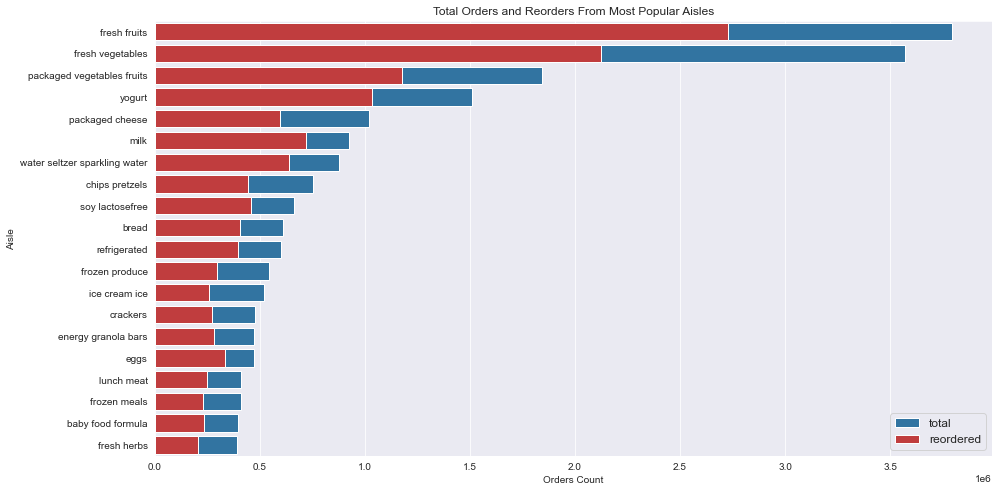

In [19]:
fig, ax = plt.subplots(figsize = (15,8))
ax = sns.barplot(y = temp_df.aisle[0:20], x = temp_df.total[0:20], color=color[0], label = "total")
ax = sns.barplot(y = temp_df.aisle[0:20], x = temp_df.reorders[0:20], color=color[3], label = "reordered")
ax.set_ylabel("Aisle")
ax.set_xlabel("Orders Count")
ax.set_title("Total Orders and Reorders From Most Popular Aisles")
ax.legend(loc = 4, prop={'size': 12})
plt.show()

In [20]:
temp_df["reorder_ratio"] = temp_df.reorders/temp_df.total
temp_df = temp_df.sort_values("reorder_ratio", ascending=False).reset_index()

#### 20 Aisles with Highest Reorder Ratio

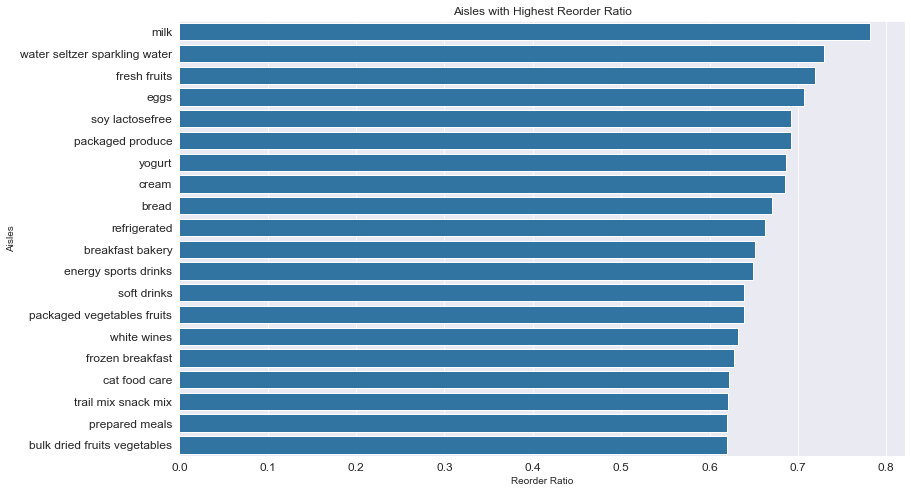

In [21]:
fig, ax = plt.subplots(figsize = (13,8))
ax = sns.barplot(y = temp_df.aisle[0:20], x = temp_df.reorder_ratio[0:20], color=color[0])
ax.set_ylabel("Aisles")
ax.set_xlabel("Reorder Ratio")
ax.set_title("Aisles with Highest Reorder Ratio")
ax.tick_params(axis = 'both', labelsize = 12)
plt.show()

#### 20 Aisles with Lowest Reorder Ratio

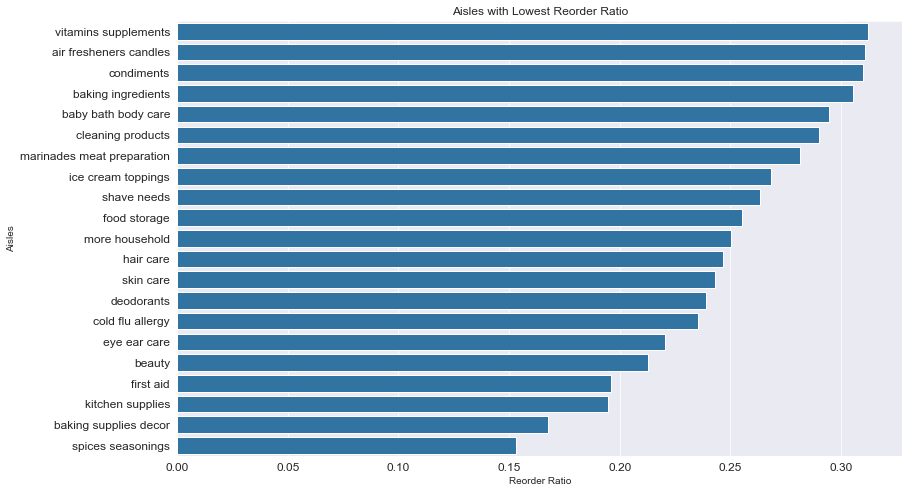

In [22]:
fig, ax = plt.subplots(figsize = (13,8))
ax = sns.barplot(y = temp_df.aisle[-21:], x = temp_df.reorder_ratio[-21:], color=color[0])
ax.set_ylabel("Aisles")
ax.set_xlabel("Reorder Ratio")
ax.set_title("Aisles with Lowest Reorder Ratio")
ax.tick_params(axis = 'both', labelsize = 12)
plt.show()

### Departments

In [23]:
temp_df = order_products.groupby("department")["reordered"].agg(['count', 'sum']).rename(columns = {'count':'total','sum':'reorders'})
temp_df = temp_df.sort_values('total', ascending=False).reset_index()

#### Total Orders and Reorders From Departments

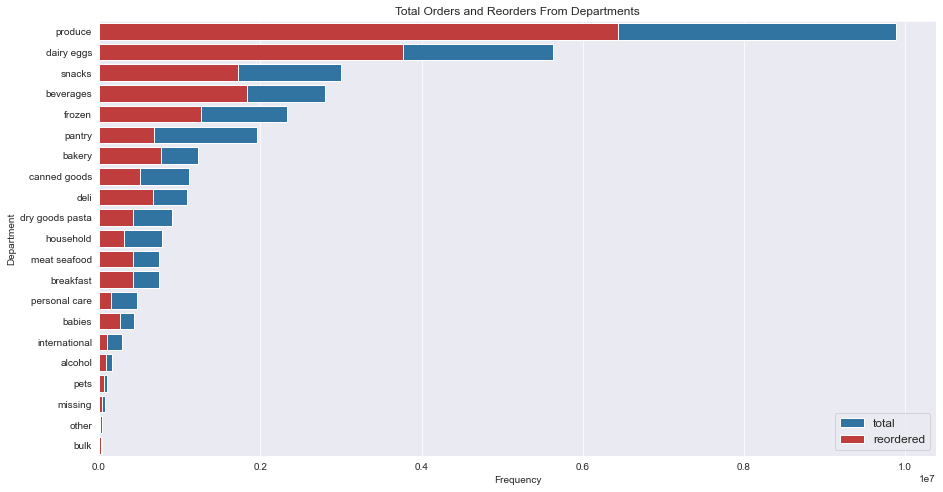

In [24]:
fig, ax = plt.subplots(figsize = (15,8))
ax = sns.barplot(y = temp_df.department, x = temp_df["total"], color=color[0], label = "total")
ax = sns.barplot(y = temp_df.department, x = temp_df["reorders"], color=color[3], label = "reordered")
ax.set_ylabel("Department")
ax.set_xlabel("Frequency")
ax.legend(loc = 4, prop={'size': 12})
ax.set_title("Total Orders and Reorders From Departments")
plt.show()

In [25]:
temp_df["reorder_ratio"] = temp_df.reorders/temp_df.total
temp_df = temp_df.sort_values("reorder_ratio", ascending=False).reset_index()

#### Departments with Highest Reorder Ratio

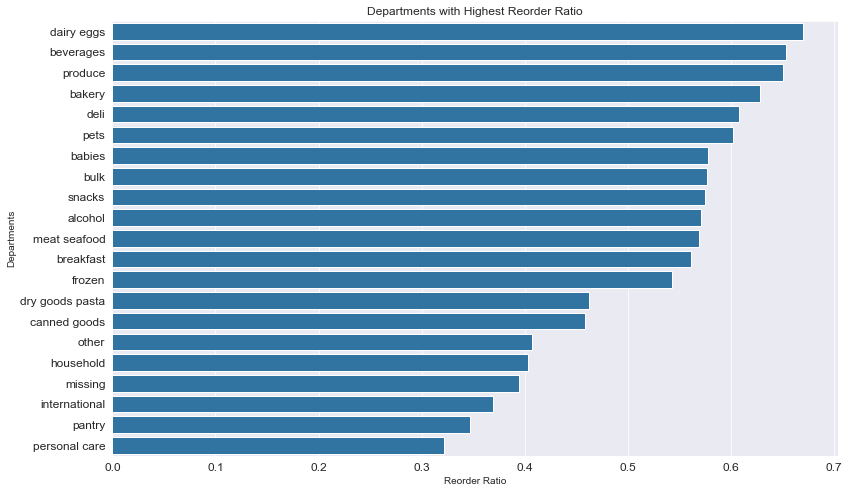

In [26]:
fig, ax = plt.subplots(figsize = (13,8))
ax = sns.barplot(y = temp_df.department, x = temp_df.reorder_ratio, color=color[0])
ax.set_ylabel("Departments")
ax.set_xlabel("Reorder Ratio")
ax.set_title("Departments with Highest Reorder Ratio")
ax.tick_params(axis = 'both', labelsize = 12)
plt.show()

### Products

In [27]:
temp_df = order_products.groupby("product_name")["reordered"].agg(['count', 'sum']).rename(columns = {'count':'total','sum':'reorders'})
temp_df = temp_df.sort_values('total', ascending=False).reset_index()

#### Most Popular Products

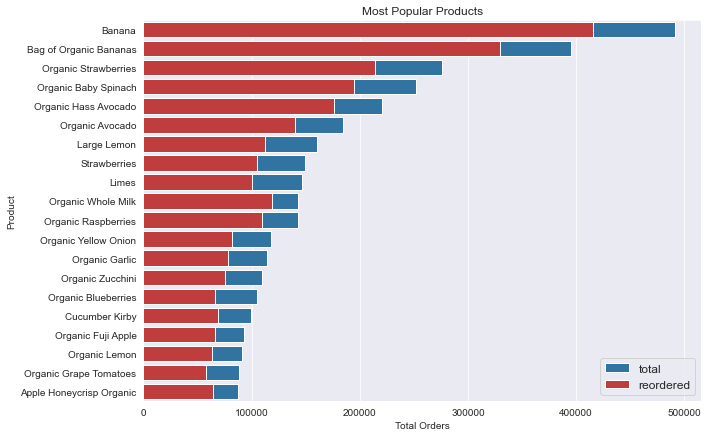

In [28]:
fig, ax = plt.subplots(figsize = (10,7))
ax = sns.barplot(y = temp_df.product_name[0:20], x = temp_df.total[0:20], color=color[0], label = "total")
ax = sns.barplot(y = temp_df.product_name[0:20], x = temp_df.reorders[0:20], color=color[3], label = "reordered")
ax.set_ylabel("Product")
ax.set_xlabel("Total Orders")
ax.set_title("Most Popular Products")
ax.legend(loc = 4, prop={'size': 12})
plt.show()

In [29]:
temp_df["reorder_ratio"] = temp_df.reorders/temp_df.total
temp_df.sort_values("reorder_ratio", ascending=False).head(10)

,product_name,total,reorders,reorder_ratio
23853,Raw Veggie Wrappers,69,65.0,0.942029
21388,Serenity Ultimate Extrema Overnight Pads,90,84.0,0.933333
40147,Orange Energy Shots,13,12.0,0.923077
20296,Chocolate Love Bar,102,94.0,0.921569
30746,Soy Powder Infant Formula,35,32.0,0.914286
28078,Simply Sleep Nighttime Sleep Aid,45,41.0,0.911111
35213,"Energy Shot, Grape Flavor",22,20.0,0.909091
32316,Russian River Valley Reserve Pinot Noir,30,27.0,0.900000
23918,Bars Peanut Butter,69,62.0,0.898551
24218,Soy Crisps Lightly Salted,67,60.0,0.895522


#### Product Users

In [30]:
product_unique_users = order_products.groupby('product_name')['user_id'].nunique().reset_index().rename(columns={'user_id':'total_users'})
product_unique_users.sort_values('total_users', ascending = False).head(10)

,product_name,total_users
3677,Banana,76125
3472,Bag of Organic Bananas,65655
31923,Organic Strawberries,61129
28843,Organic Baby Spinach,56766
22415,Large Lemon,48614
23422,Limes,46658
42908,Strawberries,44857
30300,Organic Hass Avocado,44704
28807,Organic Avocado,43954
29011,Organic Blueberries,38720


In [31]:
product_unique_users = product_unique_users.merge(temp_df, on='product_name', how='left')
product_unique_users.sort_values("reorder_ratio", ascending=False).head(20)

,product_name,total_users,total,reorders,reorder_ratio
37379,Raw Veggie Wrappers,4,69,65.0,0.942029
39870,Serenity Ultimate Extrema Overnight Pads,6,90,84.0,0.933333
28415,Orange Energy Shots,1,13,12.0,0.923077
8537,Chocolate Love Bar,8,102,94.0,0.921569
41723,Soy Powder Infant Formula,3,35,32.0,0.914286
40458,Simply Sleep Nighttime Sleep Aid,4,45,41.0,0.911111
13844,"Energy Shot, Grape Flavor",2,22,20.0,0.909091
38793,Russian River Valley Reserve Pinot Noir,3,30,27.0,0.900000
3832,Bars Peanut Butter,7,69,62.0,0.898551
41712,Soy Crisps Lightly Salted,7,67,60.0,0.895522


#### Cumulative Sum of Unique Users Per Product

In [32]:
temp_df = product_unique_users.sort_values("total_users", ascending=False)
temp_df['cum_users'] = temp_df['total_users'].cumsum()
temp_df = temp_df.reset_index(drop=True)
temp_df.head()

,product_name,total_users,total,reorders,reorder_ratio,cum_users
0,Banana,76125,491291,415166.0,0.845051,76125
1,Bag of Organic Bananas,65655,394930,329275.0,0.833755,141780
2,Organic Strawberries,61129,275577,214448.0,0.778178,202909
3,Organic Baby Spinach,56766,251705,194939.0,0.774474,259675
4,Large Lemon,48614,160792,112178.0,0.697659,308289


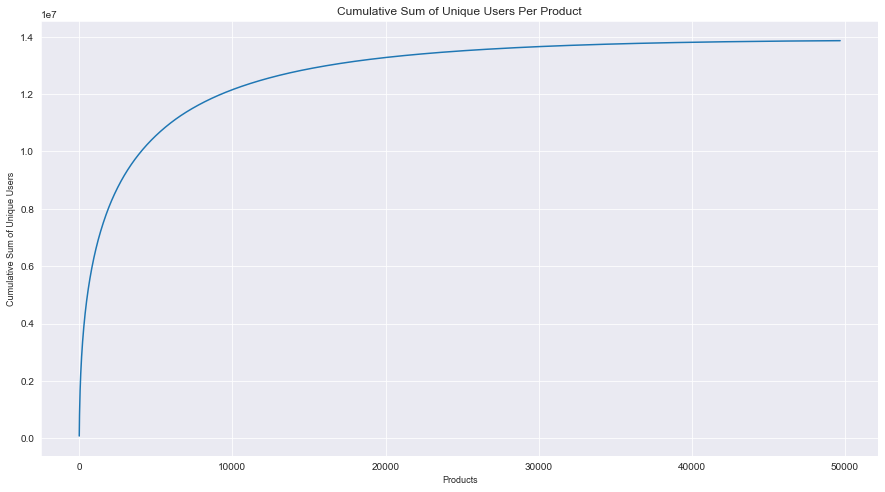

In [33]:
fig, ax = plt.subplots(figsize=(15,8))
ax = sns.lineplot(x = temp_df.index, y=temp_df.cum_users)
ax.set_xlabel("Products", size = 9)
ax.set_ylabel("Cumulative Sum of Unique Users", size = 9)
ax.set_title("Cumulative Sum of Unique Users Per Product", size = 12)
plt.show()

#### Total Product Orders VS Total Unique Product Buyers

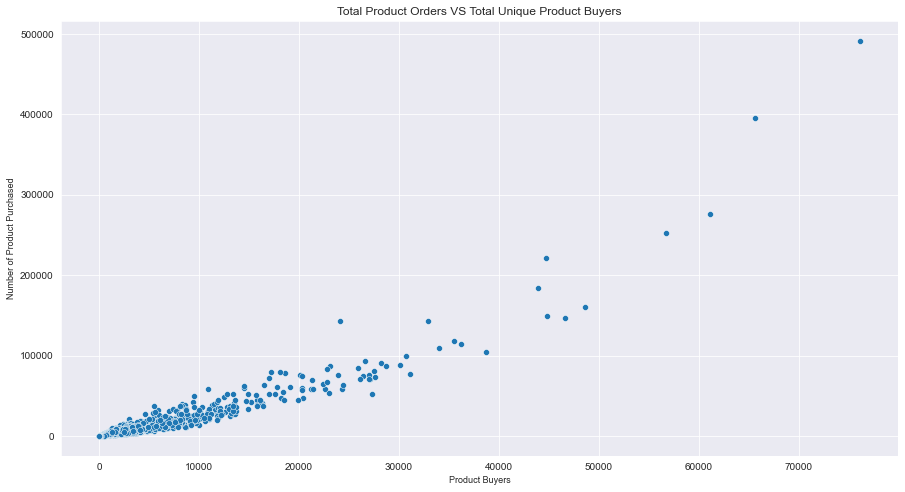

In [34]:
fig, ax = plt.subplots(figsize=(15,8))
ax = sns.scatterplot(y = product_unique_users.total, x = product_unique_users.total_users)
ax.set_xlabel("Product Buyers", size = 9)
ax.set_ylabel("Number of Product Purchased", size = 9)
ax.set_title("Total Product Orders VS Total Unique Product Buyers", size = 12)
plt.show()

#### Reorder Percentage VS Total Orders

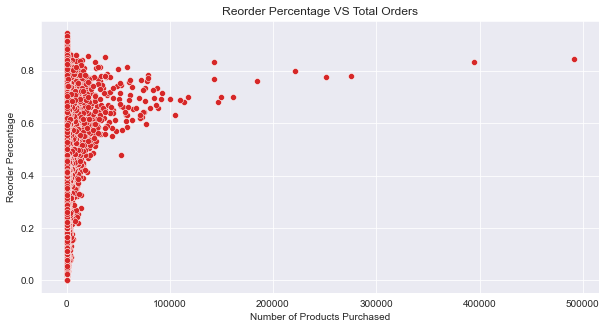

In [35]:
fig, ax = plt.subplots(figsize=(10,5))
ax = sns.scatterplot(x = product_unique_users.total, y = product_unique_users.reorder_ratio, color = color[3])
ax.set_xlabel("Number of Products Purchased")
ax.set_ylabel("Reorder Percentage")
ax.set_title("Reorder Percentage VS Total Orders")
plt.show()

#### Reorder Percentage VS Total Unique Users

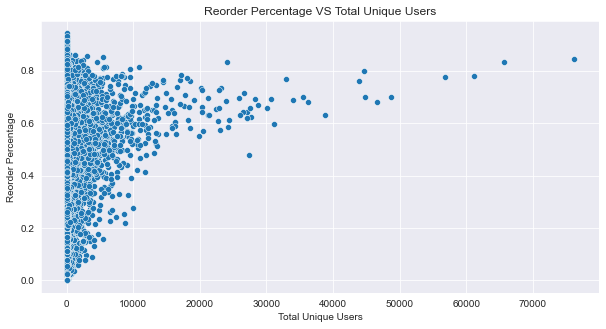

In [36]:
fig, ax = plt.subplots(figsize=(10,5))
ax = sns.scatterplot(x = product_unique_users.total_users, y = product_unique_users.reorder_ratio, color = color[0])
ax.set_xlabel("Total Unique Users")
ax.set_ylabel("Reorder Percentage")
ax.set_title("Reorder Percentage VS Total Unique Users")
plt.show()

#### Organic Vs Inorganic

In [37]:
product_unique_users['Organic'] = product_unique_users.product_name.str.contains("Organic")
product_unique_users.head()

,product_name,total_users,total,reorders,reorder_ratio,Organic
0,#2 Coffee Filters,534,799,265.0,0.331665,False
1,#2 Cone White Coffee Filters,11,14,3.0,0.214286,False
2,#2 Mechanical Pencils,9,9,0.0,0.000000,False
3,#4 Natural Brown Coffee Filters,157,247,90.0,0.364372,False
4,& Go! Hazelnut Spread + Pretzel Sticks,81,174,93.0,0.534483,False


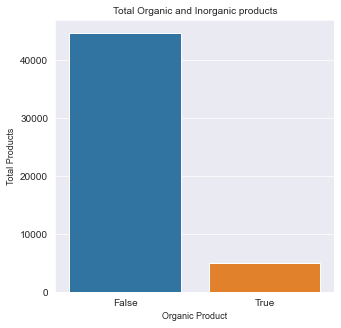

In [38]:
fig, ax = plt.subplots(figsize = (5,5))
ax = sns.barplot(x = product_unique_users.groupby('Organic').size().index, y = product_unique_users.groupby('Organic').size().values)
ax.set_xlabel("Organic Product", size = 9)
ax.set_ylabel("Total Products", size = 9)
ax.set_title("Total Organic and Inorganic products", size = 10)
plt.show()

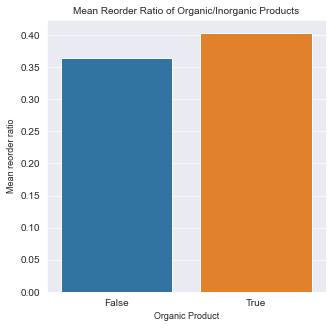

In [39]:
fig, ax = plt.subplots(figsize = (5,5))
ax = sns.barplot(x = product_unique_users.groupby('Organic')['reorder_ratio'].mean().index, y = product_unique_users.groupby('Organic')['reorder_ratio'].mean().values)
ax.set_xlabel("Organic Product", size = 9)
ax.set_ylabel("Mean reorder ratio", size = 9)
ax.set_title("Mean Reorder Ratio of Organic/Inorganic Products", size = 10)
plt.show()

#### Add to Cart Order VS Reorder  

In [40]:
temp_df = order_products.groupby('add_to_cart_order')['reordered'].mean().reset_index()
temp_df.head()

,add_to_cart_order,reordered
0,1,0.679302
1,2,0.677135
2,3,0.658426
3,4,0.637350
4,5,0.617598


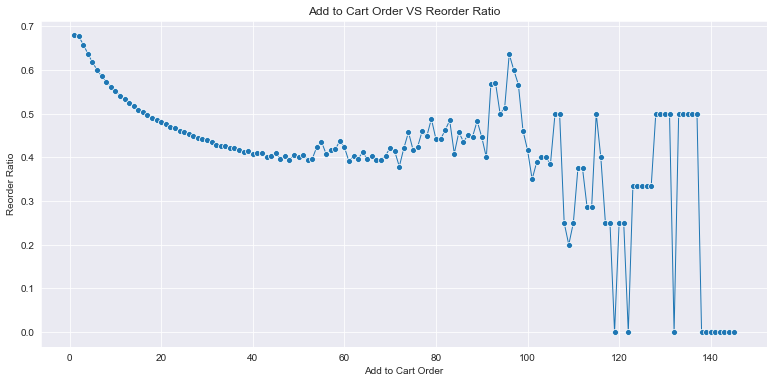

In [41]:
fig, ax = plt.subplots(figsize=(13,6))
ax = sns.lineplot(x=temp_df.add_to_cart_order, y=temp_df.reordered, lw = 1, marker='o')
ax.set_xlabel("Add to Cart Order")
ax.set_ylabel("Reorder Ratio")
ax.set_title("Add to Cart Order VS Reorder Ratio")
plt.show()

#### Most Popular Products on different days

In [42]:
temp_df = order_products.groupby(['order_dow', 'product_name']).size().reset_index(name='counts')
temp_df = temp_df.sort_values(['order_dow', 'counts'], ascending=[True, False])
temp_df = temp_df.groupby('order_dow').head(5).reset_index(drop = True)

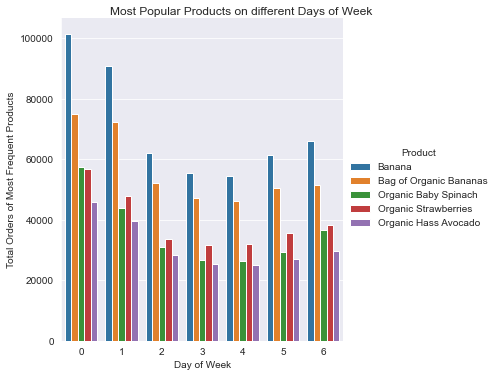

In [43]:
ax = sns.catplot(x="order_dow", y="counts", hue="product_name", data=temp_df, kind="bar", legend=False)
ax.add_legend(title="Product")
ax.set_axis_labels("Day of Week", "Total Orders of Most Frequent Products")
ax.fig.suptitle("Most Popular Products on different Days of Week", va="baseline", ha="center")
ax.savefig("Most Popular Products on Different Days of Week.png")